<a href="https://colab.research.google.com/github/vimuth97/Pump-It-Up/blob/main/pump_it_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [254]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [255]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

# for dirname, _, filenames in os.walk('/content/drive'):
#     for filename in filenames:
#       print(os.path.join(dirname, filename))

train_values = pd.read_csv("/content/drive/MyDrive/Pump it up/training values.csv")
train_labels = pd.read_csv("/content/drive/MyDrive/Pump it up/training labels.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Pump it up/test set.csv")

In [256]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [257]:
train_values.shape

(59400, 40)

Checking whether the dataset is balanced or not

In [258]:
print(train_labels['status_group'].value_counts())

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


In [259]:
test_data.isnull().sum().sort_values(ascending = False)

scheme_name              7092
scheme_management         969
installer                 877
funder                    869
public_meeting            821
permit                    737
subvillage                 99
ward                        0
lga                         0
district_code               0
region_code                 0
region                      0
waterpoint_type_group       0
population                  0
num_private                 0
wpt_name                    0
latitude                    0
longitude                   0
gps_height                  0
date_recorded               0
amount_tsh                  0
basin                       0
recorded_by                 0
waterpoint_type             0
water_quality               0
source_class                0
source_type                 0
source                      0
quantity_group              0
quantity                    0
quality_group               0
payment_type                0
construction_year           0
payment   

In [260]:
amount = train_values['amount_tsh']
print(amount.max())
print(amount.min())

350000.0
0.0


Standardise `amount_tsh`, `population` because they have a large ranges and may contain outliers.
However tree based classifiers does not require standardisation 

In [261]:
train_values[['amount_tsh', 'population', 'num_private', 'gps_height']] = StandardScaler().fit_transform(train_values[['amount_tsh', 'population', 'num_private', 'gps_height']])
print(train_values[['amount_tsh', 'population', 'num_private', 'gps_height']])

       amount_tsh  population  num_private  gps_height
0        1.895665   -0.150399    -0.038749    1.041252
1       -0.105970    0.212290    -0.038749    1.054237
2       -0.097630    0.148660    -0.038749    0.025541
3       -0.105970   -0.258570    -0.038749   -0.584751
4       -0.105970   -0.381587    -0.038749   -0.964200
...           ...         ...          ...         ...
59395   -0.102634   -0.116463    -0.038749    0.781553
59396    1.461977   -0.262812    -0.038749    0.784439
59397   -0.105970   -0.381587    -0.038749   -0.964200
59398   -0.105970   -0.381587    -0.038749   -0.964200
59399   -0.105970   -0.063439    -0.038749   -0.688631

[59400 rows x 4 columns]


**Onehot encoding**

In [262]:
train_values_ohe = pd.get_dummies(train_values, prefix=["public_meeting", "permit"], columns=["public_meeting", "permit"], dummy_na=False)
# ohe_2 = pd.get_dummies(train_values.permit, prefix="permit")
train_values_ohe.shape

(59400, 42)

 Remove `region` feature because `region_code` provide coded version of same information

In [263]:
train_values_drop_region = train_values_ohe.drop(['region'], axis=1)

Pre-process `longitude` and `gps_height` by replacing 0 with mean value of each district.
In the dataset region>district>subvillage but subvillage has `na` values hence district is chosen to calculate the mean

In [264]:
print("minimum longitude", train_values_drop_region.longitude.min())
print("number of unavailable latitudes", len(train_values_drop_region[(train_values_drop_region['latitude']==-0.00000002)]))

minimum longitude 0.0
number of unavailable latitudes 1812


In [265]:
grouped = train_values_drop_region.groupby("district_code")

def replaceLongitude(group):
  mask = group==0
  group[mask] = group[~mask].mean()
  return group

def replaceLatitude(group):
  mask = group==-0.00000002
  group[mask] = group[~mask].mean()
  return group

mean_longitude = grouped.longitude.transform(replaceLongitude)
mean_latitude = grouped.latitude.transform(replaceLatitude)

train_values_drop_region.longitude = mean_longitude
train_values_drop_region.latitude = mean_latitude

In [266]:
#check for correctness of above process
print("minimum longitude:", train_values_drop_region.longitude.min()) 
print("number of unavailable latitudes:", len(train_values_drop_region[(train_values_drop_region['latitude']==-0.00000002)]))

minimum longitude: 29.6071219
number of unavailable latitudes: 0


In [267]:
print(train_values_drop_region.shape)

(59400, 41)


Preprocess `date_recorded` feature

In [268]:
train_values_drop_region['date_recorded'] =  pd.to_datetime(train_values['date_recorded'])
train_values_drop_region['num_days'] = (train_values_drop_region['date_recorded'] - pd.Timestamp.now())/np.timedelta64(1, 'D')
train_values_drop_region['num_days'] = StandardScaler().fit_transform(train_values_drop_region[['num_days']])
train_values_drop_date = train_values_drop_region.drop(['date_recorded'], axis=1)
print(train_values_drop_date.shape,'\n',train_values_drop_date['num_days'])

(59400, 41) 
 0       -1.141136
1        1.022152
2        0.995223
3        0.911444
4       -0.779092
           ...   
59395    1.195693
59396   -0.979562
59397   -1.057357
59398   -1.159088
59399   -1.114207
Name: num_days, Length: 59400, dtype: float64


In [269]:
encoded_features = ['id','latitude','longitude','gps_height','date_recorded','amount_tsh','num_private',
                    'region_code','district_code','population','public_meeting','construction_year','permit',
                    'num_days','public_meeting_False','public_meeting_True','permit_False','permit_True','installer',
                    'wpt_name','subvillage','recorded_by']

limit_train = int(train_values_drop_date.shape[0]*0.03/100)
limit_test = int(test_data.shape[0]*0.03/100)

for column in train_values_drop_date.columns:
  if column not in encoded_features:
    train_values_drop_date[column] = train_values_drop_date[column].str.lower()
    feature_values=train_values_drop_date[column].value_counts()
    rare_features=feature_values[feature_values < limit_train]
    train_values_drop_date[column].replace(to_replace = list(rare_features.keys()), value = 'other', inplace = True)
    if ('other' in train_values_drop_date[column].value_counts().index):
      print('Changed', train_values_drop_date[column].value_counts()['other'], 'rows to other in column', column)

    train_values_drop_date[column], _ = train_values_drop_date[column].factorize(na_sentinel=-1)     # label encoding
    
    # same encoding for test data set
    feature_values_test=test_data[column].value_counts()
    rare_features_test=feature_values_test[feature_values_test < limit_test]
    test_data[column].replace(to_replace = list(_), value = [ x for x in range(len(list(_)))], inplace = True)
    test_data[column].fillna(-1, inplace = True)
    for i,j in test_data[column].iteritems():
      if type(j) is str:
        test_data.loc[i, column]=len(list(_))

Changed 4308 rows to other in column funder
Changed 1 rows to other in column lga
Changed 7739 rows to other in column ward
Changed 767 rows to other in column scheme_management
Changed 10466 rows to other in column scheme_name
Changed 6432 rows to other in column extraction_type
Changed 6430 rows to other in column extraction_type_group
Changed 6430 rows to other in column extraction_type_class
Changed 844 rows to other in column management
Changed 943 rows to other in column management_group
Changed 1054 rows to other in column payment
Changed 1054 rows to other in column payment_type
Changed 212 rows to other in column source
Changed 278 rows to other in column source_type
Changed 6387 rows to other in column waterpoint_type
Changed 6387 rows to other in column waterpoint_type_group


In [270]:
train_values_drop_name = train_values_drop_date.drop(['wpt_name'], axis=1)    #drop 'wpt_name' (name of the waterpoint) due to highcardinality and less relevance to the prediction

In [271]:
train_values_drop_name['construction_year'].replace(to_replace = 0, value = 1959, inplace = True)    #impute 'construction_year' with 1959 because 1960 is earliest available data

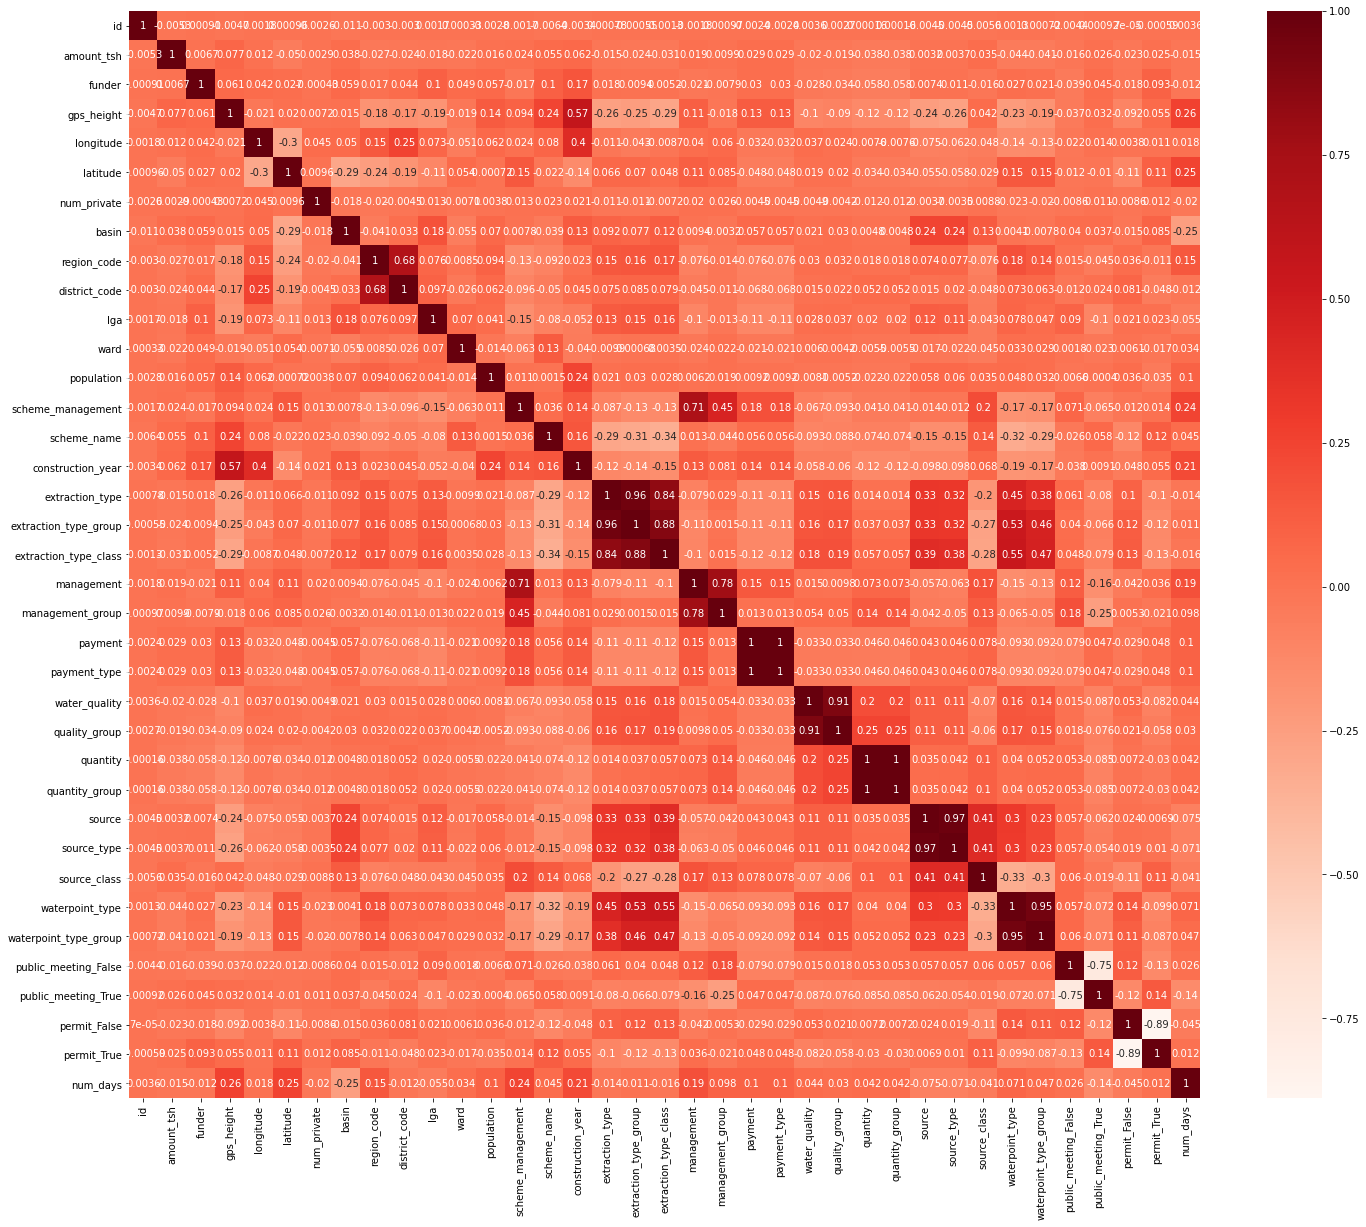

In [272]:
#Using Pearson Correlation
plt.figure(figsize=(24,20))
cor = train_values_drop_name.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Remove following features due to high corelation

In [273]:
train_corr = train_values_drop_name.drop(['extraction_type_group', 'quantity_group', 'payment_type', 'quality_group', 'waterpoint_type_group',
                                          'source_type'], axis=1)
train_corr = train_corr.drop(['installer', 'subvillage', 'recorded_by', 'id'], axis=1)

In [274]:
# Utility functions from Tutorial
def make_mi_scores(X, y, features):
    X_mi = X.copy()
    mi_scores = mutual_info_classif(X_mi, y, discrete_features=features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [275]:
# # mutual inofrmation
# features = [True, False, True, True, False,True, True, True, True, True, True ]
# mi_scores = make_mi_scores(X_new, Y, features)
# print(mi_scores.head(20))

# plt.figure(dpi=100, figsize=(8, 5))
# plot_mi_scores(mi_scores.head(20))


In [276]:
# X_mi = X_new.drop(['Embarked_Q'], axis=1) # remove Embarked_Q feature due to low mutual information score

In [277]:
# preprocess test data
test_data[['amount_tsh', 'population', 'num_private', 'gps_height']] = StandardScaler().fit_transform(test_data[['amount_tsh', 'population', 'num_private', 'gps_height']])
test_data['construction_year'].replace(to_replace = 0, value = 1959, inplace = True)
test_data_ohe = pd.get_dummies(test_data, prefix=["public_meeting", "permit"], columns=["public_meeting", "permit"], dummy_na=False)


test_data_ohe['date_recorded'] =  pd.to_datetime(test_data_ohe['date_recorded'])
test_data_ohe['num_days'] = (test_data_ohe['date_recorded'] - pd.Timestamp.now())/np.timedelta64(1, 'D')
test_data_ohe['num_days'] = StandardScaler().fit_transform(test_data_ohe[['num_days']])


# test_new = test_data.join([test_1, test_2, test_3])
test_dropped = test_data_ohe.drop(['extraction_type_group', 'quantity_group', 'payment_type', 'quality_group', 'waterpoint_type_group',
                              'source_type','installer', 'subvillage', 'recorded_by', 'id', 'region', 'date_recorded', 'wpt_name'], axis=1)


grouped = test_dropped.groupby("district_code")
mean_longitude = grouped.longitude.transform(replaceLongitude)
mean_latitude = grouped.latitude.transform(replaceLatitude)

test_dropped.longitude = mean_longitude
test_dropped.latitude = mean_latitude

In [278]:
test_dropped.shape

(14850, 30)

In [279]:
# test-train split
X_train, X_test, Y_train, Y_test = train_test_split(train_corr, train_labels.status_group, test_size=0.2, random_state=23)

print(X_train.shape, X_test.shape)

(47520, 30) (11880, 30)


Hyper parameter tuning

In [305]:
# GridSearch for random forest classifier
param_grid = {
    # 'bootstrap': [True],
    'criterion': ['gini'],
    # 'max_depth': [None],
    # 'max_features': [None],
    # 'min_samples_leaf': [1],
    'min_samples_split': [10],
    # 'max_samples': [None],
    'n_estimators': [800],
}
num_folds = 10
# Create a base model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = num_folds, verbose = 4)

Train and select best model

In [306]:
# grid_search.fit(X_train, Y_train)
grid_search.fit(train_corr, train_labels.status_group)     # for submission
grid_search.best_params_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] criterion=gini, min_samples_split=10, n_estimators=800 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, min_samples_split=10, n_estimators=800, score=0.820, total= 1.6min
[CV] criterion=gini, min_samples_split=10, n_estimators=800 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  criterion=gini, min_samples_split=10, n_estimators=800, score=0.826, total= 1.6min
[CV] criterion=gini, min_samples_split=10, n_estimators=800 ..........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


[CV]  criterion=gini, min_samples_split=10, n_estimators=800, score=0.818, total= 1.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.9min remaining:    0.0s


[CV] criterion=gini, min_samples_split=10, n_estimators=800 ..........
[CV]  criterion=gini, min_samples_split=10, n_estimators=800, score=0.814, total= 1.6min
[CV] criterion=gini, min_samples_split=10, n_estimators=800 ..........
[CV]  criterion=gini, min_samples_split=10, n_estimators=800, score=0.829, total= 1.6min
[CV] criterion=gini, min_samples_split=10, n_estimators=800 ..........
[CV]  criterion=gini, min_samples_split=10, n_estimators=800, score=0.811, total= 1.6min
[CV] criterion=gini, min_samples_split=10, n_estimators=800 ..........
[CV]  criterion=gini, min_samples_split=10, n_estimators=800, score=0.823, total= 1.6min
[CV] criterion=gini, min_samples_split=10, n_estimators=800 ..........
[CV]  criterion=gini, min_samples_split=10, n_estimators=800, score=0.812, total= 1.6min
[CV] criterion=gini, min_samples_split=10, n_estimators=800 ..........
[CV]  criterion=gini, min_samples_split=10, n_estimators=800, score=0.813, total= 1.6min
[CV] criterion=gini, min_samples_split=1

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 16.1min finished


{'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 800}

In [302]:
model = grid_search.best_estimator_

Predict using selected model

In [303]:
y_pred = model.predict(X_test)

Evaluation

In [304]:
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
print('\nPredicted Labels')
print('functional','functional_needs_repair','non_functional')
print(confusion_matrix(Y_test,y_pred, normalize='true', labels=['functional','functional needs repair','non functional']))

Accuracy: 0.8172558922558922

Predicted Labels
functional functional_needs_repair non_functional
[[0.9034832  0.01565137 0.08086543]
 [0.52705882 0.31647059 0.15647059]
 [0.20075338 0.01218702 0.78705961]]


Save save predictions for test set

In [ ]:
y_pred = model.predict(test_dropped)
results = pd.DataFrame()
results["id"] = test_data.id
results["status_group"] = y_pred
results.to_csv('output3.csv', index=False)